In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.compat.v2 as tf

from keras import backend
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.utils.vis_utils import plot_model

from PIL import Image

from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [2]:
class CONFIG:
    INDEXS = ["R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]
    N_SPLITS = 5

# Load Dataset

In [3]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [4]:
training_dataset = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
training_dataset.sample(n=10)

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
124666,1155,0,17,22,0.0,18.0,1.935673,1.0,2.988078,0.0,...,0,0,1,0,0,0,0,0,0,1
52835,441554,0,60660,4,0.0,2326.0,68.915819,42.0,135.290168,0.0,...,0,0,0,0,0,0,0,1,0,0
132216,1501468,0,50185,8,0.0,1175.0,131.313356,92.0,154.879580,0.0,...,0,0,0,0,0,1,0,0,0,49
125425,246883,15,10884,24,0.0,780.0,21.007576,6.0,62.481403,0.0,...,1,0,0,1,0,0,0,0,0,0
53954,175201,0,54849,36,0.0,806.0,125.469264,85.0,122.271119,0.0,...,0,0,0,0,0,0,0,0,1,14
58903,358398,0,8153,18,0.0,291.0,34.222923,25.0,32.956600,0.0,...,0,0,0,0,0,0,1,0,0,1
141056,812001,0,95068,24,0.0,891.0,164.372340,83.0,182.088591,0.0,...,0,0,0,0,0,1,0,0,0,5
89071,18236,0,81,4,0.0,127.0,13.188679,8.0,17.887549,0.0,...,0,0,0,0,0,1,0,0,0,0
20470,672411,1,14221,9,0.0,451.0,30.040834,13.0,53.055002,0.0,...,0,0,0,0,1,0,0,0,0,9
13660,413095,0,19301,24,0.0,405.0,37.918848,23.0,47.376693,0.0,...,0,0,0,1,0,0,0,0,0,14


# Data Preprocessing

In [5]:
post_published_weekday = (training_dataset["Post published weekday-Monday"]
                          + training_dataset["Post published weekday-Tuesday"]
                          + training_dataset["Post published weekday-Wednesday"]
                          + training_dataset["Post published weekday-Thursday"]
                          + training_dataset["Post published weekday-Friday"]).astype("int")
post_published_weekend = (training_dataset["Post published weekday-Sunday"]
                          + training_dataset["Post published weekday-Saturday"]).astype("int")
training_dataset.insert(46, "Post published weekday", post_published_weekday)
training_dataset.insert(47, "Post published weekend", post_published_weekend)
training_dataset.drop(
    ["Post published weekday-Saturday",
     "Post published weekday-Sunday",
     "Post published weekday-Monday",
     "Post published weekday-Tuesday",
     "Post published weekday-Wednesday",
     "Post published weekday-Thursday",
     "Post published weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,0,1,0,0,17


In [6]:
base_datetime_weekday = (training_dataset["Base DateTime weekday-Monday"]
                          + training_dataset["Base DateTime weekday-Tuesday"]
                          + training_dataset["Base DateTime weekday-Wednesday"]
                          + training_dataset["Base DateTime weekday-Thursday"]
                          + training_dataset["Base DateTime weekday-Friday"]).astype("int")
base_datetime_weekend = (training_dataset["Base DateTime weekday-Sunday"]
                          + training_dataset["Base DateTime weekday-Saturday"]).astype("int")
training_dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
training_dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
training_dataset.drop(
    ["Base DateTime weekday-Saturday",
     "Base DateTime weekday-Sunday",
     "Base DateTime weekday-Monday",
     "Base DateTime weekday-Tuesday",
     "Base DateTime weekday-Wednesday",
     "Base DateTime weekday-Thursday",
     "Base DateTime weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,25,166,2,0,24,1,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,70,132,1,0,24,1,0,0,1,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,26,133,2,0,24,1,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,67,131,1,0,24,1,0,1,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,65,142,5,0,24,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,16,77,2123,0,24,1,0,1,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,4,130,474,0,24,1,0,1,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,12,12,1511,0,24,1,0,1,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,31,149,1099,0,24,1,0,1,0,17


In [7]:
features = training_dataset.iloc[:, :43]
features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,CC5,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,25,166,2,0,24,1,0,1,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,70,132,1,0,24,1,0,0,1
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,26,133,2,0,24,1,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,67,131,1,0,24,1,0,1,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,65,142,5,0,24,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1940,16,77,2123,0,24,1,0,1,0
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,155,4,130,474,0,24,1,0,1,0
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,207,12,12,1511,0,24,1,0,1,0
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,-459,31,149,1099,0,24,1,0,1,0


In [8]:
labels = training_dataset.iloc[:, -1:]
labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
199025,203
199026,42
199027,51
199028,17


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3, random_state=42)

# Fully Connected Neural Network

## Normalization

In [10]:
def normalize(X_train, X_test, y_train, y_test):
    x_scaler = StandardScaler()
    x_scaler.fit(X_train)
    X_train_norm = x_scaler.transform(X_train)
    X_test_norm = x_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_scaler.fit(y_train)
    y_train_norm = y_scaler.transform(y_train)
    y_test_norm = y_scaler.transform(y_test)
    return X_train_norm, X_test_norm, y_train_norm, y_test_norm

## Data Preprocessing

### Random Forest

In [11]:
def feature_selection(X_train_norm_df, y_train_norm_df):
    rf_model = RandomForestRegressor(
        max_depth=12,
        min_samples_split=0.0001,
        n_estimators=30,
        random_state=42,
    )
    rf_model.fit(X_train_norm_df, y_train_norm_df.values.ravel())
    
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [X_train_norm_df.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    sfm = SelectFromModel(rf_model, threshold=0.02, prefit=True)
    selected_feature_ids = sfm.get_support()
    selected_features = X_train_norm_df.columns[selected_feature_ids]
    return selected_features

### PCA

In [12]:
def pca(X_train_norm_df):
    pca = PCA()
    pca.fit(X_train_norm_df)
    X_train_norm_df_reduction = pca.transform(X_train_norm_df)
    
    plt.plot([i for i in range(X_train_norm_df.shape[1])], 
         [np.sum(pca.explained_variance_ratio_[:i]) for i in range(X_train_norm_df.shape[1])])
    plt.show()

## Loss Function

https://github.com/keras-team/keras/blob/master/keras/losses.py

In [13]:
# loss = |y_true * (y_pred - y_true)|
# loss = mean(abs(y_true * (y_pred - y_true)), axis=-1)
def y_true_mean_absolute_error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return backend.mean(tf.abs(y_true * (y_pred - y_true)), axis=-1)

## Model Initialization

In [14]:
def create_model(input_shape):
    # Sequential
    model = Sequential()
    model.add(Dense(units=500,
                    activation='relu',
                    input_shape=(input_shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(units=300,
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=200,
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='adam', loss=y_true_mean_absolute_error)
    print(model.summary())
    return model

## Model Training

In [15]:
def train_model(model, X_train_norm, y_train_norm, X_test_norm, y_test_norm):
    train = model.fit(X_train_norm,
                      y_train_norm,
                      epochs=500,
                      batch_size=1024,
                      verbose=1,
                      validation_data=(X_test_norm, y_test_norm))
    model.save('model_fcnn.h5')
    predict = model.predict(X_test_norm)
    plt.plot(train.history['loss'])  
    plt.plot(train.history['val_loss'])  
    plt.title('Model loss')  
    plt.ylabel('Loss')  
    plt.xlabel('Epoch')  
    plt.legend(['Train', 'Test'], loc='upper left')  
    plt.show()
    plt.figure(figsize=(10, 15))
    plot_model(model, to_file='model_fcnn.png', show_shapes=True)
    img = Image.open('model_fcnn.png', 'r')
    plt.imshow(np.asarray(img))
    plt.show()
    return predict

In [16]:
def plot_test_predict(y_train, y_test_norm, predict, axes=None, k=None):
    y_scaler = StandardScaler()
    y_scaler.fit(y_train)
    test_predict = pd.concat(
        [pd.DataFrame(y_scaler.inverse_transform(y_test_norm)),
         pd.DataFrame(y_scaler.inverse_transform(predict.reshape(-1, 1)))
    ], axis=1)
    headers =  ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict, ax=axes[k]).set_title("Test Predict Line Plot k = " + str(k))
    else:
        sns.lineplot(data=test_predict).set_title("Test Predict Line Plot")
    plt.show()
    if axes is not None and k is not None:
        sns.scatterplot(data=test_predict, x="Test", y="Predict", ax=axes[k]).set_title("Test Predict Sctter Plot k = " + str(k))
    else:
        sns.scatterplot(data=test_predict, x="Test", y="Predict").set_title("Test Predict Sctter Plot")
    plt.show()
    x_residual = y_scaler.inverse_transform(predict.reshape(-1, 1))
    y_residual = y_scaler.inverse_transform(y_test_norm) * (y_scaler.inverse_transform(predict.reshape(-1, 1)) - y_scaler.inverse_transform(y_test_norm))
    sns.residplot(x=x_residual, lowess=True, y=y_residual).set_title("Residuals")
    plt.show()
    x_residual = y_scaler.inverse_transform(predict.reshape(-1, 1))
    y_residual = y_scaler.inverse_transform(y_test_norm)
    sns.residplot(x=x_residual, lowess=True, y=y_residual).set_title("Residuals")
    plt.show()

## Model Evaluation

In [17]:
def evaluate(model, y_train, X_test_norm, y_test_norm, predict):
    y_scaler = StandardScaler()
    y_scaler.fit(y_train)
    
    # R-Squared
    r2 = r2_score(y_scaler.inverse_transform(y_test_norm),
                  y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Explained Variance Score
    ev = explained_variance_score(y_scaler.inverse_transform(y_test_norm),
                                  y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Max Error
    me = max_error(y_scaler.inverse_transform(y_test_norm), 
                   y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_scaler.inverse_transform(y_test_norm),
                                  y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Mean Squared Error
    mse = mean_squared_error(y_scaler.inverse_transform(y_test_norm),
                             y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_scaler.inverse_transform(y_test_norm), 
                                      y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Hit@10
    hit = np.abs(
        y_scaler.inverse_transform(y_test_norm).flatten() - 
        y_scaler.inverse_transform(predict.reshape(-1, 1)).flatten()
    ) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_scaler.inverse_transform(y_test_norm).flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(y_scaler.inverse_transform(predict.reshape(-1, 1)).flatten())
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [18]:
def train_final_model():
    # Normalization
    X_train_norm, X_test_norm, y_train_norm, y_test_norm = normalize(X_train, X_test, y_train, y_test)
    
    # Data Preprocessing
    X_train_norm_df = pd.DataFrame(data=X_train_norm)
    X_test_norm_df = pd.DataFrame(data=X_test_norm)
    y_train_norm_df = pd.DataFrame(data=y_train_norm)
    y_test_norm_df = pd.DataFrame(data=y_test_norm)

    selected_features = feature_selection(X_train_norm_df, y_train_norm_df)
    
    X_train_norm_df = X_train_norm_df[selected_features]
    X_test_norm_df = X_test_norm_df[selected_features]
    
    pca(X_train_norm_df)
    
    X_train_norm = X_train_norm_df.to_numpy()
    X_test_norm = X_test_norm_df.to_numpy()
    y_train_norm = y_train_norm_df.to_numpy()
    y_test_norm = y_test_norm_df.to_numpy()

    # Model Initialization
    model = create_model(X_train_norm_df.shape[1])

    # Model Training
    predict = train_model(model, X_train_norm, y_train_norm, X_test_norm, y_test_norm)
    plot_test_predict(y_train, y_test_norm, predict)

    # Model Evaluation
    r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, y_train, X_test_norm, y_test_norm, predict)

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

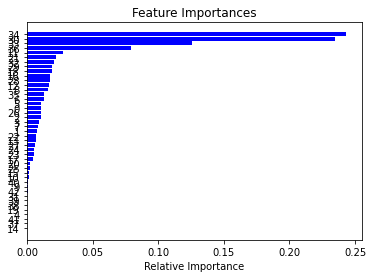

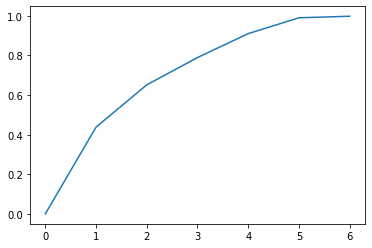

2021-11-09 20:56:22.374649: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 20:56:22.543896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               4000      
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               150300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

137/137 [==============================] - 2s 13ms/step - loss: 0.4644 - val_loss: 0.3629
Epoch 69/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4628 - val_loss: 0.3605
Epoch 70/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4568 - val_loss: 0.3670
Epoch 71/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4542 - val_loss: 0.3684
Epoch 72/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4595 - val_loss: 0.3710
Epoch 73/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4607 - val_loss: 0.3739
Epoch 74/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4490 - val_loss: 0.3625
Epoch 75/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4476 - val_loss: 0.3664
Epoch 76/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4518 - val_loss: 0.3935
Epoch 77/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4512 - 

137/137 [==============================] - 2s 12ms/step - loss: 0.4516 - val_loss: 0.3673
Epoch 148/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4376 - val_loss: 0.3639
Epoch 149/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4350 - val_loss: 0.3633
Epoch 150/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4271 - val_loss: 0.3624
Epoch 151/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4232 - val_loss: 0.3644
Epoch 152/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4406 - val_loss: 0.3788
Epoch 153/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4348 - val_loss: 0.3684
Epoch 154/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4192 - val_loss: 0.3805
Epoch 155/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4281 - val_loss: 0.3667
Epoch 156/500
137/137 [==============================] - 2s 12ms/step - loss: 

Epoch 226/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4175 - val_loss: 0.3761
Epoch 227/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4133 - val_loss: 0.3521
Epoch 228/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4023 - val_loss: 0.3896
Epoch 229/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4002 - val_loss: 0.3746
Epoch 230/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4010 - val_loss: 0.3577
Epoch 231/500
137/137 [==============================] - 2s 11ms/step - loss: 0.3928 - val_loss: 0.3705
Epoch 232/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4064 - val_loss: 0.3851
Epoch 233/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4100 - val_loss: 0.3667
Epoch 234/500
137/137 [==============================] - 2s 11ms/step - loss: 0.4244 - val_loss: 0.3477
Epoch 235/500
137/137 [==============================] - 2s 11ms

Epoch 305/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3896 - val_loss: 0.3578
Epoch 306/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4070 - val_loss: 0.3715
Epoch 307/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4074 - val_loss: 0.3671
Epoch 308/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3903 - val_loss: 0.3626
Epoch 309/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4009 - val_loss: 0.3685
Epoch 310/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3806 - val_loss: 0.3535
Epoch 311/500
137/137 [==============================] - 2s 12ms/step - loss: 0.4017 - val_loss: 0.3639
Epoch 312/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3910 - val_loss: 0.3578
Epoch 313/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3806 - val_loss: 0.3617
Epoch 314/500
137/137 [==============================] - 2s 12ms

Epoch 384/500
137/137 [==============================] - 2s 14ms/step - loss: 0.3760 - val_loss: 0.3673
Epoch 385/500
137/137 [==============================] - 2s 15ms/step - loss: 0.3715 - val_loss: 0.3631
Epoch 386/500
137/137 [==============================] - 2s 14ms/step - loss: 0.3777 - val_loss: 0.3618
Epoch 387/500
137/137 [==============================] - 2s 14ms/step - loss: 0.3622 - val_loss: 0.3614
Epoch 388/500
137/137 [==============================] - 2s 15ms/step - loss: 0.3784 - val_loss: 0.3768
Epoch 389/500
137/137 [==============================] - 2s 14ms/step - loss: 0.3670 - val_loss: 0.3693
Epoch 390/500
137/137 [==============================] - 2s 14ms/step - loss: 0.3826 - val_loss: 0.3648
Epoch 391/500
137/137 [==============================] - 2s 13ms/step - loss: 0.3685 - val_loss: 0.3626
Epoch 392/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3795 - val_loss: 0.3633
Epoch 393/500
137/137 [==============================] - 2s 12ms

Epoch 463/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3765 - val_loss: 0.3508
Epoch 464/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3736 - val_loss: 0.3762
Epoch 465/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3693 - val_loss: 0.3814
Epoch 466/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3460 - val_loss: 0.3742
Epoch 467/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3849 - val_loss: 0.3724
Epoch 468/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3710 - val_loss: 0.3722
Epoch 469/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3581 - val_loss: 0.3648
Epoch 470/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3824 - val_loss: 0.3779
Epoch 471/500
137/137 [==============================] - 2s 12ms/step - loss: 0.3746 - val_loss: 0.3609
Epoch 472/500
137/137 [==============================] - 2s 12ms

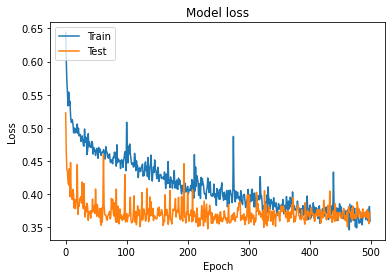

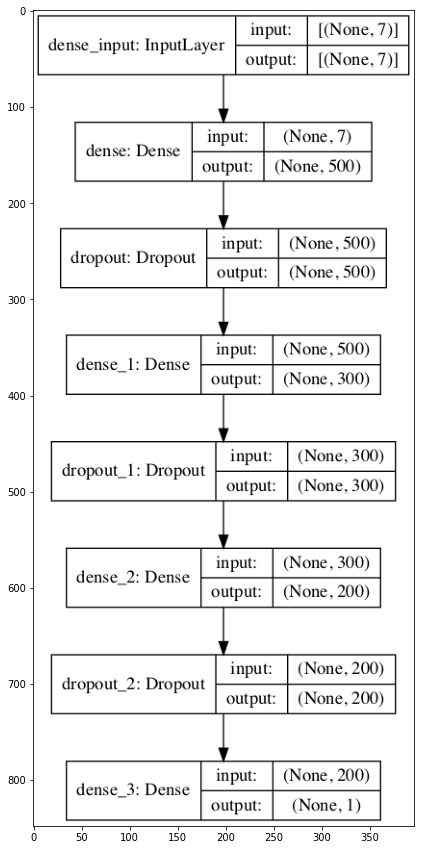

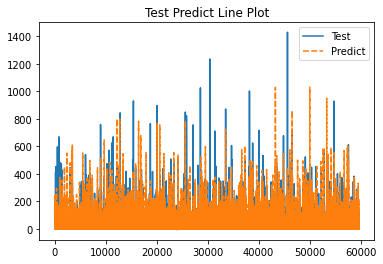

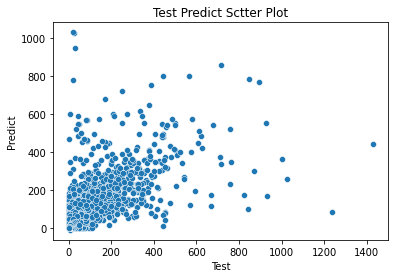

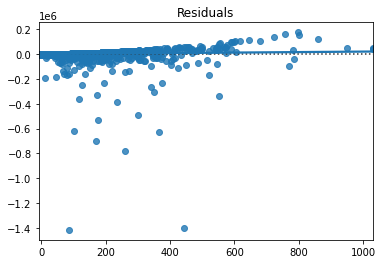

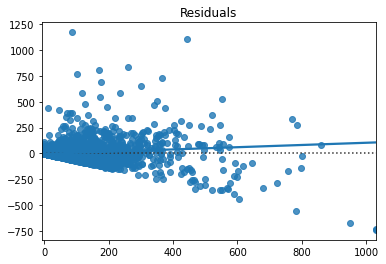

       Index         Mean
0         R2     0.502816
1         EV     0.503774
2         ME  1147.726364
3    MEAN_AE     4.509003
4        MSE   510.170811
5  MEDIAN_AE     0.004510
6     HIT@10     0.909779
7    HIT@100     0.460000


In [19]:
train_final_model()